In [5]:
# 导入需要的工具包
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from d2l import torch as d2l
from sklearn.datasets import load_iris
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

## L1 正则化

要保证权重向量比较小，最常用方法是将其范数作为惩罚项加到最小化损失的问题中。将原来的训练目标最小化训练标签上的预测损失，调整为最小化预测损失和惩罚项之和。如果我们的权重向量增长的太大，我们的学习算法可能会更集中于最小化权重范数。

In [6]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [7]:
def l1_penalty(w):
    w = torch.abs(w)
    return torch.sum(w) 

def train(lambd):
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L1范数惩罚项，
            # 广播机制使l1_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l1_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.527101516723633


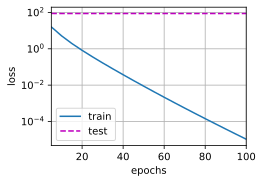

In [8]:
# lambd设置为0代表不使用L1正则化
train(lambd=0)

w的L2范数是： 0.07032167166471481


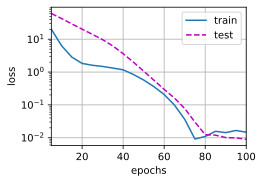

In [9]:
# lambd设置为非0代表使用L1正则化
train(lambd=3)

## L2正则化


In [10]:
def l2_penalty(w):
    return torch.sum(w.pow(2))

def train(lambd):
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 简洁实现

比对权重衰减的计算公式和L2正则化的计算公式可以发现，L2正则化与权重衰减是等价的。\
权重衰减在神经网络优化中很常用，所以深度学习框架为了便于我们使用权重衰减，将权重衰减集成到优化算法中，以便与任何损失函数结合使用。

In [11]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.802907943725586


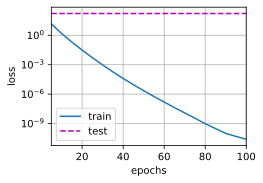

In [12]:
# 参数设置为0代表不使用L2正则化
train_concise(0)

w的L2范数： 0.4724077582359314


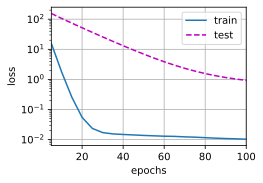

In [13]:
# lambd设置为非0代表使用L2正则化
train_concise(3)


## 暂退法（Dropout）

回想一下带有1个隐藏层和5个隐藏单元的多层感知机。 当我们将暂退法应用到隐藏层，以概率p将隐藏单元置为零时， 结果可以看作是一个只包含原始神经元子集的网络。 \
由于掩蔽某些神经元后，该神经层的活性值的分布会发生变化，而在测试阶段时不使用暂退，这会使得训练和测试两个阶段该层神经元的活性值的分布不一致，并对之后的神经层产生影响。因此，为了在使用暂退法时不改变活性值的方差，将暂退保留后的神经元活性值方法为原来的1/(1-p)倍。这样可以保证下一个神经层的输入在训练和测试阶段的方差基本一致。

In [14]:
class Dropout:
    def __init__(self, drop_rate):
        self.mask = None
        self.drop_rate = drop_rate
    
    def forward(self, inputs):
        if self.drop_rate == 1:
            return torch.zeros_like(inputs)
    # 在drop_rate等于0时，所有元素都被保留
        if self.drop_rate == 0:
            return inputs
        mask = (torch.rand(inputs.shape) > self.drop_rate).float()
        self.mask = mask
        
        return mask * inputs / (1.0 - self.drop_rate)
    
    def __call__(self, inputs):
        return self.forward(inputs)
    
    def backward(self, outputs_grad):
        return torch.mutiply(outputs_grad, self.mask)/(1-self.drop_rate)

In [15]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
Drop_all = Dropout(1)
Drop_half = Dropout(0.5)
print(X)
print(Drop_all(X))
print(Drop_half(X))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12.,  0.],
        [ 0.,  0.,  0.,  0., 24., 26., 28.,  0.]])


### 简洁实现

现在，为我们的模型增加Pytorch框架已经够实现的暂退层，并重新训练一次鸢尾花训练数据集。你也可以在优化器中加入权重衰减，看看结果的区别。

In [16]:
class FeedForwardDropOut(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, drop_rate):
        super(FeedForwardDropOut,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        # dropout层
        self.droplayer = nn.Dropout(drop_rate)
        
    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act1(outputs)
        outputs = self.droplayer(outputs)
        outputs = self.fc2(outputs)
        outputs = self.act1(outputs)
        outputs = self.fc3(outputs)
        
        return outputs
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, drop_rate):
        super(FeedForward,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        # dropout层
        # self.droplayer = nn.Dropout(drop_rate)
        
    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act1(outputs)
        # outputs = self.droplayer(outputs)
        outputs = self.fc2(outputs)
        outputs = self.act1(outputs)
        outputs = self.fc3(outputs)
        
        return outputs

In [17]:
from torch.utils.data import Dataset, DataLoader

def load_data(shuffle=True):
    x = torch.tensor(load_iris().data)
    y = torch.tensor(load_iris().target)
    
    # 数据归一化
    x_min = torch.min(x, dim=0).values
    x_max = torch.max(x, dim=0).values
    x = (x-x_min)/(x_max-x_min)
    
    if shuffle:
        idx = torch.randperm(x.shape[0])
        x = x[idx]
        y = y[idx]
    return x, y

class IrisDataset(Dataset):
    def __init__(self, mode='train', num_train=120, num_dev=15):
        super(IrisDataset,self).__init__()
        x, y = load_data(shuffle=True)
        if mode == 'train':
            self.x, self.y = x[:num_train], y[:num_train]
        elif mode == 'dev':
            self.x, self.y = x[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
        else:
            self.x, self.y = x[num_train + num_dev:], y[num_train + num_dev:]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [18]:
batch_size = 16

train_dataset = IrisDataset(mode='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

In [19]:
class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        # 用于计算评价指标
        self.metric = metric
        
        # 记录训练过程中的评价指标变化
        self.dev_scores = []
        # 记录训练过程中的损失变化
        self.train_epoch_losses = []
        self.dev_losses = []
        # 记录全局最优评价指标
        self.best_score = 0
    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型设置为训练模式，此时模型的参数会被更新
        self.model.train()
        
        num_epochs = kwargs.get('num_epochs', 0)
        log_steps = kwargs.get('log_steps', 100)
        save_path = kwargs.get('save_path','best_model.pth')
        eval_steps = kwargs.get('eval_steps', 0)
        # 运行的step数，不等于epoch数
        global_step = 0
        
        if eval_steps:
            if dev_loader is None:
                raise RuntimeError('Error: dev_loader can not be None!')
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None')
                
        # 遍历训练的轮数
        for epoch in range(num_epochs):
            total_loss = 0
            # 遍历数据集
            for step, data in enumerate(train_loader):
                x, y = data
                logits = self.model(x.float())
                loss = self.loss_fn(logits, y.long())
                total_loss += loss
                if step%log_steps == 0:
                    print(f'loss:{loss.item():.5f}')
                    
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            # 每隔一定轮次进行一次验证，由eval_steps参数控制，可以采用不同的验证判断条件
            if eval_steps != 0 :
                if (epoch+1) % eval_steps ==  0:

                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f'[Evalute] dev score:{dev_score:.5f}, dev loss:{dev_loss:.5f}')
                
                    if dev_score > self.best_score:
                        self.save_model(f'model_{epoch+1}.pth')
                    
                        print(f'[Evaluate]best accuracy performance has been updated: {self.best_score:.5f}-->{dev_score:.5f}')
                        self.best_score = dev_score
                    
                # 验证过程结束后，请记住将模型调回训练模式   
                    self.model.train()
            
            global_step += 1
            # 保存当前轮次训练损失的累计值
            train_loss = (total_loss/len(train_loader)).item()
            self.train_epoch_losses.append((global_step,train_loss))
        self.save_model(f'{save_path}.pth')   
        print('[Train] Train done')
        
    # 模型评价阶段
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None
        # 将模型设置为验证模式，此模式下，模型的参数不会更新
        self.model.eval()
        global_step = kwargs.get('global_step',-1)
        total_loss = 0
        self.metric.reset()
        
        for batch_id, data in enumerate(dev_loader):
            x, y = data
            logits = self.model(x.float())
            loss = self.loss_fn(logits, y.long()).item()
            total_loss += loss 
            self.metric.update(logits, y)
            
        dev_loss = (total_loss/len(dev_loader))
        self.dev_losses.append((global_step, dev_loss))
        dev_score = self.metric.accumulate()
        self.dev_scores.append(dev_score)
        return dev_score, dev_loss
    
    # 模型预测阶段，
    def predict(self, x, **kwargs):
        self.model.eval()
        logits = self.model(x)
        return logits
    
    # 保存模型的参数
    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        
    # 读取模型的参数
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


def plot_training_loss_acc(runner, fig_name, fig_size=(16, 6), sample_step=20, loss_legend_loc='upper right', acc_legend_loc='lower right',
                          train_color = '#8E004D', dev_color = '#E20079', fontsize='x-large', train_linestyle='-', dev_linestyle='--'):
    plt.figure(figsize=fig_size)
    plt.subplot(1,2,1)
    train_items = runner.train_epoch_losses[::sample_step]
    train_steps = [x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]
    
    plt.plot(train_steps, train_losses, color=train_color, linestyle=train_linestyle, label='Train loss')
    if len(runner.dev_losses) > 0:
        dev_steps = [x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color=dev_color, linestyle=dev_linestyle,label='dev loss')
    
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.legend(loc=loss_legend_loc)
    if len(runner.dev_scores) > 0:
        plt.subplot(1,2,2)
        plt.plot(dev_steps, runner.dev_scores, color=dev_color, linestyle=dev_linestyle, label='dev accuracy')
        
        plt.ylabel('score')
        plt.xlabel('step')
        plt.legend(loc=acc_legend_loc)
    # 将绘制结果保存
    plt.savefig(fig_name)
    plt.show()


loss:1.14704
loss:1.09764
loss:1.10849
loss:1.09834
loss:1.10216
loss:1.07299
loss:1.11514
loss:1.08760
loss:1.09438
loss:1.06837
loss:1.07422
loss:1.06986
loss:1.05962
loss:1.04556
loss:1.07964
loss:0.87497
loss:0.97659
loss:0.89806
loss:0.73638
loss:0.78726
loss:0.90510
loss:0.60073
loss:0.72089
loss:0.79315
loss:0.69354
loss:0.84519
loss:0.85461
loss:0.56008
loss:0.63728
loss:0.57759
loss:0.59247
loss:0.86340
loss:0.40112
loss:0.76220
loss:0.81479
loss:0.59677
loss:0.49927
loss:0.71962
loss:0.72960
loss:0.55740
loss:0.66978
loss:0.81037
loss:0.66610
loss:0.73275
loss:0.65783
loss:0.60731
loss:0.66800
loss:0.84506
loss:0.68814
loss:0.58491
[Train] Train done


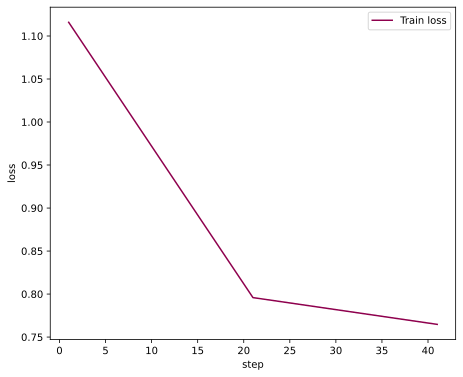

In [20]:
input_size = 4
hidden_size = [6, 8]
output_size = 3
drop_rate = 0.6
model = FeedForwardDropOut(input_size, hidden_size, output_size, drop_rate)
# 损失函数
loss_fn = F.cross_entropy
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
# 实例化辅助runner类
runner = Runner(model, optimizer, loss_fn)
# 模型训练
runner.train(train_loader, num_epochs=50, log_steps=10)
plot_training_loss_acc(runner, 'chapter7_24batchsize_dropout.pdf')

loss:1.05264
loss:1.08962
loss:1.04842
loss:0.99510
loss:0.92833
loss:0.81969
loss:0.68026
loss:0.53223
loss:0.46536
loss:0.48582
loss:0.35980
loss:0.33734
loss:0.62912
loss:0.30266
loss:0.22751
loss:0.18967
loss:0.51172
loss:0.47742
loss:0.12406
loss:0.13565
loss:0.32345
loss:0.21521
loss:0.06339
loss:0.14569
loss:0.10798
loss:0.19659
loss:0.31982
loss:0.17565
loss:0.10742
loss:0.15774
loss:1.04239
loss:0.26033
loss:0.19282
loss:0.07525
loss:2.01413
loss:0.15361
loss:0.11158
loss:0.10803
loss:0.05357
loss:0.20816
loss:0.34884
loss:0.18456
loss:0.23092
loss:0.07882
loss:0.18752
loss:0.08372
loss:0.01053
loss:0.02370
loss:0.09186
loss:0.16352
[Train] Train done


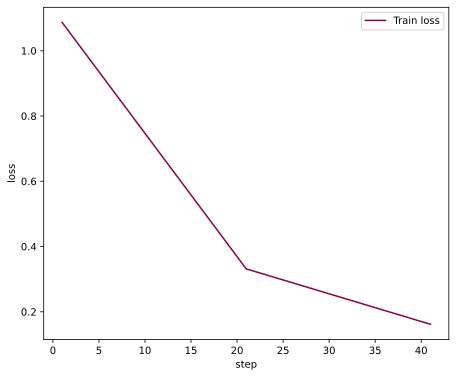

In [21]:
input_size = 4
hidden_size = [6, 8]
output_size = 3
drop_rate = 0.6
model = FeedForward(input_size, hidden_size, output_size, drop_rate)
# 损失函数
loss_fn = F.cross_entropy
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
# 实例化辅助runner类
runner = Runner(model, optimizer, loss_fn)
# 模型训练
runner.train(train_loader, num_epochs=50, log_steps=10)
plot_training_loss_acc(runner, 'chapter7_24batchsize_dropout.pdf')


## 注意力机制

In [22]:
# 导入必要的库
import os
import math
import torch 
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
from torch.utils import data

为了直观地显示注意力权重，首先定义可视化函数，其输入的形状是（行数，列数，查询数目，键的数目）

In [23]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

下面我们使用两个简单的例子进行演示。在第一个例子中，当查询和键相同时，注意力权重为1，否则为0，我们用torch.eye来模拟这种情况。

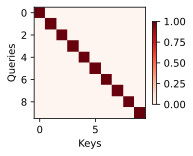

In [24]:
# torch.eye 返回一个对角线元素为1，其余元素为0的矩阵。
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

在第二个例子中，我们使用torch.rand来随机生成矩阵中的数值，即查询和键值之间的注意力权重是随机给定的。

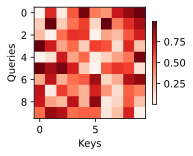

In [25]:
attention_weights = torch.rand(1, 1, 10, 10)
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 掩码softmax操作

在实际情况下，常采用小批量梯度下降法，这引发了两个需要注意的事情：对于同一批次中的输入序列应该补齐到同意长度；补齐字符不应该影响注意力分布的计算结果。

softmax操作用于输出一个概率分布作为注意力权重。 在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。为了仅将有意义的词元作为值来获取注意力汇聚，我们可以指定一个有效序列长度（即词元的个数），以便在计算softmax时过滤掉超出指定范围的位置。 

在具体的实现中，补齐的字符会被填充为一些很小的负数，在经过Softmax后得到的权重为0，不会影响注意力分布的计算结果。所以说，填充的无意义的字符会参与注意力分布的计算，但不会影响最终的结果。

In [26]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

下面展示两个例子，假设有两个矩阵表示的样本，这两个样本的有效长度分别为3和4。经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [27]:
masked_softmax(torch.rand(3, 8, 5), torch.tensor([2,2,2]))

tensor([[[0.5108, 0.4892, 0.0000, 0.0000, 0.0000],
         [0.5328, 0.4672, 0.0000, 0.0000, 0.0000],
         [0.3611, 0.6389, 0.0000, 0.0000, 0.0000],
         [0.5056, 0.4944, 0.0000, 0.0000, 0.0000],
         [0.3739, 0.6261, 0.0000, 0.0000, 0.0000],
         [0.5514, 0.4486, 0.0000, 0.0000, 0.0000],
         [0.4158, 0.5842, 0.0000, 0.0000, 0.0000],
         [0.4548, 0.5452, 0.0000, 0.0000, 0.0000]],

        [[0.4854, 0.5146, 0.0000, 0.0000, 0.0000],
         [0.4622, 0.5378, 0.0000, 0.0000, 0.0000],
         [0.5848, 0.4152, 0.0000, 0.0000, 0.0000],
         [0.5614, 0.4386, 0.0000, 0.0000, 0.0000],
         [0.3478, 0.6522, 0.0000, 0.0000, 0.0000],
         [0.5442, 0.4558, 0.0000, 0.0000, 0.0000],
         [0.6934, 0.3066, 0.0000, 0.0000, 0.0000],
         [0.5864, 0.4136, 0.0000, 0.0000, 0.0000]],

        [[0.6729, 0.3271, 0.0000, 0.0000, 0.0000],
         [0.5635, 0.4365, 0.0000, 0.0000, 0.0000],
         [0.5329, 0.4671, 0.0000, 0.0000, 0.0000],
         [0.5843, 0.4157, 0

同样，我们也可以使用二维张量，为矩阵样本中的每一行指定有效长度。

In [28]:
masked_softmax(torch.rand(2, 2, 5), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3624, 0.3937, 0.2440, 0.0000, 0.0000]],

        [[0.5061, 0.4939, 0.0000, 0.0000, 0.0000],
         [0.2437, 0.2920, 0.2356, 0.2287, 0.0000]]])

## 加性注意力

现在，我们来实现注意力分布计算公式中的注意力打分函数 (书中P194, 公式8.1)。首先是加性注意力模型，假设输入序列为X，其形状为 (B, L, D)，其中B为批量大小，L为序列长度，D为特征维度，我们引入一个任务相关的查询向量q，q也是可以学习的参数。加性注意力计算公式见书中P194, 公式8.2。一般来说，当查询和键是不同长度的矢量时，我们可以使用加性注意力作为评分函数。

In [29]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

根据加性注意力的代码可以发现，加性注意力拥有可以学习的参数，即线性层。

下面是一个示例。其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小）， 实际输出为 (2, 1, 20)、(2, 10, 2)和(2, 10, 4)。 注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。

In [30]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

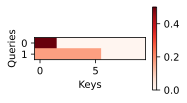

In [31]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), 
              xlabel='Keys', ylabel='Queries')

## 缩放点积模型

   现在，我们实现缩放点积模型。顾名思义，缩放点积模型由两个功能组成，点积操作和缩放操作。
   
   点积模型需要实现三个功能：注意力打分函数, 注意力分布计算和加权平均。使用点积可以得到计算效率更高的评分函数，但是点积操作要求查询和键具有相同的长度。 假设查询和键的所有元素都是独立的随机变量，并且都满足零均值和单位方差，那么两个向量的点积的均值为0，方差为d。为确保无论向量长度如何，点积的方差在不考虑向量长度的情况下仍然是1， 我们将点积除以标准差，这就是缩放点积注意力。   

In [32]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        # 使用暂退法进行模型正则化
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [33]:
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

In [34]:
#作业，根据缩放点积模型进行修改，改为点积注意力模型，并查看其异同
class dotProductAttention(nn.Module):
    """点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(dotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        scores = torch.bmm(queries, keys.transpose(1,2))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = dotProductAttention(0.5)
attention.eval()

output = attention(queries, keys, values, valid_lens)
print(output)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
